# QAT

载入库：

In [1]:
from torch import nn, jit
from torch.ao.quantization.quantize import convert
from torchvision.models.quantization import mobilenet_v2


def create_model(num_classes=10,
                 quantize=False,
                 pretrained=False):
    '''定义模型'''
    float_model = mobilenet_v2(pretrained=pretrained,
                               quantize=quantize)
    # 匹配 ``num_classes``
    float_model.classifier[1] = nn.Linear(float_model.last_channel,
                                          num_classes)
    return float_model

In [2]:
import torch
torch.cuda.empty_cache() # 清空 GPU 缓存
print(torch.cuda.memory_summary()) # 打印显存

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [3]:
# 设置 warnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module='.*'
)
warnings.filterwarnings(
    action='ignore',
    module='torch.ao.quantization'
)
# 载入自定义模块
from mod import load_mod
load_mod()

from helper import evaluate, print_size_of_model, load_model

def print_info(model, model_type, num_eval, criterion):
    '''打印信息'''
    print_size_of_model(model)
    top1, top5 = evaluate(model, criterion, test_iter)
    print(f'\n{model_type}：\n\t'
          f'在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.5f}')


def create_qat_model(num_classes,
                     model_path,
                     quantize=False):
    qat_model = create_model(quantize=quantize,
                             num_classes=num_classes)
    qat_model = load_model(qat_model, model_path)
    return qat_model

超参数设置：

In [4]:
saved_model_dir = 'models/'
float_model_file = 'mobilenet_pretrained_float.pth'
scripted_qat_model_file = 'mobilenet_qat_scripted_quantized.pth'
# 超参数
float_model_path = saved_model_dir + float_model_file
batch_size = 16
num_classes = 10
device = 'cuda:0'
num_epochs = 50
learning_rate = 5e-5
ylim = [0.6, 1]

# 设置评估策略
criterion = nn.CrossEntropyLoss()

加载数据集：

In [5]:
from xinet import CV

# 为了 cifar10 匹配 ImageNet，需要将其 resize 到 224
train_iter, test_iter = CV.load_data_cifar10(batch_size=batch_size,
                                             resize=224)
num_eval = sum(len(ys) for _, ys in test_iter)

Files already downloaded and verified
Files already downloaded and verified


普通策略：

loss 0.169, train acc 0.946, test acc 0.912
57.0 examples/sec on cuda:0


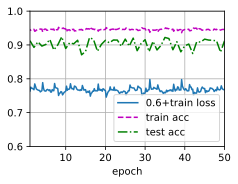

In [6]:
is_quantized_acc = False
is_freeze = False
param_group = True
qat_model = create_qat_model(num_classes, float_model_path)
CV.train_fine_tuning(qat_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=num_epochs,
                     device=device,
                     param_group=param_group,
                     is_freeze=is_freeze,
                     is_quantized_acc=is_quantized_acc,
                     need_prepare=True,
                     ylim=ylim)

冻结前几次训练的量化器以及观测器：

In [ ]:
is_quantized_acc = False
is_freeze = True
param_group = True
qat_model = create_qat_model(num_classes, float_model_path)
CV.train_fine_tuning(qat_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=num_epochs,
                     device=device,
                     param_group=param_group,
                     is_freeze=is_freeze,
                     is_quantized_acc=is_quantized_acc,
                     need_prepare=True,
                     ylim=ylim)

输出量化精度：

In [ ]:
is_quantized_acc = True
is_freeze = False
param_group = True
model_path = saved_model_dir + float_model_file
qat_model = create_qat_model(num_classes, model_path)
CV.train_fine_tuning(qat_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=num_epochs,
                     device=device,
                     param_group=param_group,
                     is_freeze=is_freeze,
                     is_quantized_acc=is_quantized_acc,
                     need_prepare=True,
                     ylim=ylim)

冻结前几次训练的观测器并且生成量化精度：

In [ ]:
is_quantized_acc = True
is_freeze = True
param_group = True
qat_model = create_qat_model(num_classes, float_model_path)
CV.train_fine_tuning(qat_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=num_epochs,
                     device=device,
                     param_group=param_group,
                     is_freeze=is_freeze,
                     is_quantized_acc=is_quantized_acc,
                     need_prepare=True,
                     ylim=ylim)